# Graph Signal Processing using TV regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, plotting
from sklearn.metrics import mean_squared_error
import pyunlocbox
from random import random
from IPython.display import display, clear_output

from scipy.spatial.distance import pdist, cdist, squareform

DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
RESULT_PATH = '../results/'
adjacency = np.loadtxt(GENERATED_PATH+'movie_ratings_adj.csv', delimiter=',')
ratings = pd.read_csv(GENERATED_PATH+'ratings_matrix.csv', index_col=0)

## Total variation regularization

The approach we take to solve the movie recommandation system is that each set of ratings coming from a user is a signal lying on the graph of movies previously constructed.

The problem is that a lot of ratings are missing. The known ratings are between 1 and 5 and the unknown ratings are equal to 0.

We try to reconstruct the signal of the ratings for all movies using a TV regularization method. Indeed because the signal of ratings is a picewise constant function it is the most appropriate approach to recover the signal.

The TV regularization method try to recover the signal $x$ by solving the optimization problem :

$$
\tilde{x}=\underset{x \in \mathbb{R}^{N}}{\arg \min } \left\{ \|A x-y\|_{2}^{2}+R_{\mathrm{tv}}(x ; G) \right\}
$$

where $R_{\mathrm{tv}}(x ; G)=\alpha\|S x\|_{1}=\alpha \sum_{w_{i j} \in E} \sqrt{w_{i j}}|x(i)-x(j)|$

## Using Movie Ratings Graph
### Small network

To begin we just use the first signal (the first user)

In [2]:
ratings[ratings > 0].count(axis=1).sort_values(ascending=False)

UserId
13     304
276    293
416    270
655    270
303    262
      ... 
300     10
242      9
565      7
558      7
855      4
Length: 943, dtype: int64

In [3]:
def compute_mean_signal(ratings, user_id):
    ratings_without_users = ratings.drop(index = user_id)
    mean_counter = ratings_without_users.copy().astype('float')
    mean_counter[mean_counter == 0] = np.nan
    mean_signal = np.nanmean(mean_counter, axis = 0)
    return mean_signal

In [4]:
user_id = 13
signal = ratings.loc[user_id].reset_index(drop = True)
indexes = np.array(signal[signal >0].index.to_list())
mean_signal = compute_mean_signal(ratings, user_id)
mean_signal = mean_signal[indexes]

We use the first 161 movies which are all rated by this user. So we can see the evolution of the MSE with the percentage of missing ratings

In [5]:
adj = adjacency[indexes][:, indexes]
signal = signal[indexes]
G = graphs.Graph(adj)
G.set_coordinates()

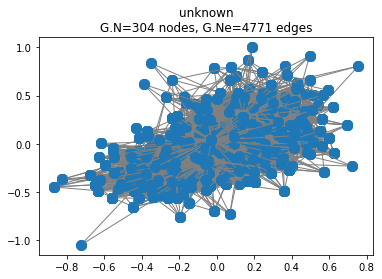

In [6]:
# Load graph
G = graphs.Graph(adj)
G.set_coordinates()
G.plot()

In [7]:
# This function solve the optimization problem of the TV regularization
def tv_reg(G, noisy, mask, gamma = 3):
    
    # Set the functions in the problem
    d = pyunlocbox.functions.dummy()
    r = pyunlocbox.functions.norm_l1()
    f = pyunlocbox.functions.norm_l2(w=mask, y=noisy, lambda_=gamma)

    # Define the solver
    G.compute_differential_operator()
    L = G.D.toarray()
    step = 0.999 / (1 + np.linalg.norm(L))
    solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

    # Solve the problem
    x0 = noisy.copy()
    prob1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000, verbosity='NONE')

    return prob1['sol']

In [8]:
# Create the mask
rs = np.random.RandomState(41)
mask = rs.rand(G.N)
mask = (mask < 0.7).astype(float)
inverse_mask = mask * -1 + 1
noisy = signal * mask

# Add the mean of ratings for each movie
noisy = noisy + mean_signal * inverse_mask

test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

We perform a validation test for the parameter gamma

Best gamma :  11.88888888888889
RMSE :  0.6174234039598672


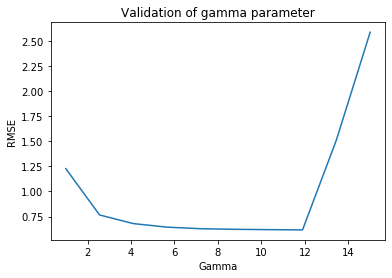

In [9]:
# Reconstruct the signal
errors = []
best_error = np.inf
best_gamma = 0
gamma_range = np.linspace(1,15,10)
for gamma in gamma_range:
    reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=gamma), 1, 5)

    test_reconstructed = reconstructed * inverse_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
    clear_output(wait = True)
    print(f'gamma: {gamma}, error {error}')
    if error < best_error:
        best_error = error
        best_gamma = gamma
    errors.append(error)

# we compute the mean squared error only between the ratings we didn't know
clear_output(wait = True)
print("Best gamma : ", best_gamma)
print("RMSE : ", best_error)

# We reconstruct the signal using the best gamma
reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=13), 1, 5)

# Plot validation
plt.figure()
plt.plot(gamma_range, errors)
plt.title("Validation of gamma parameter")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.show()

### Plot the signal
upper row is the entire available data.
the lower row shows only the test split

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


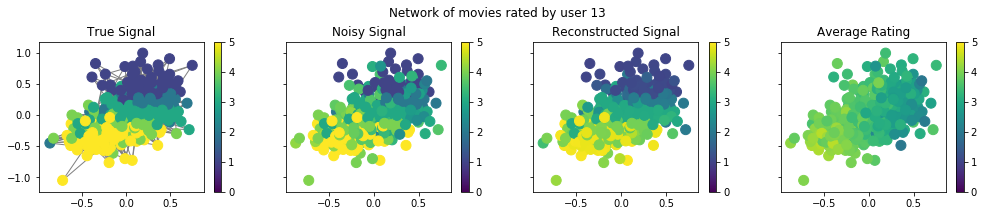

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


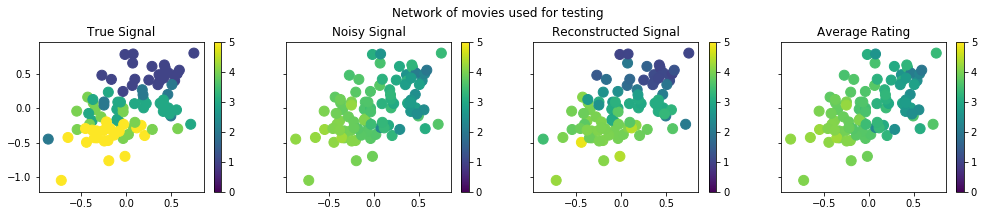

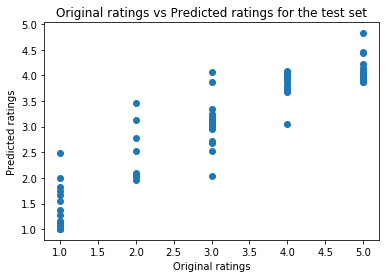

In [10]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, sharey=True, figsize=(17, 3))
limits = [0, 5]
G.plot_signal(signal, ax=ax1, limits=limits, plot_name='True Signal')
G.plot_signal(noisy, ax=ax2, limits=limits, plot_name='Noisy Signal', show_edges = False)
G.plot_signal(reconstructed, ax=ax3, limits=limits, plot_name='Reconstructed Signal', show_edges= False)
G.plot_signal(mean_signal, ax=ax4, limits=limits, plot_name='Average Rating', show_edges= False)
plt.suptitle("Network of movies rated by user 13")
plt.savefig(RESULT_PATH+'prediction_user_13.eps')
plt.subplots_adjust(top=0.82)
plt.show()


signal_red = signal.copy()
signal_red[mask != 0] = np.nan
noisy_red = noisy.copy()
noisy_red[mask != 0] = np.nan
reconstructed_red = reconstructed.copy()
reconstructed_red[mask != 0] = np.nan
mean_signal_red = mean_signal.copy()
mean_signal_red[mask != 0] = np.nan

fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, sharey=True, figsize=(17, 3))
G.plot_signal(signal_red, ax=ax1, limits=limits, plot_name='True Signal', show_edges = False)
G.plot_signal(noisy_red, ax=ax2, limits=limits, plot_name='Noisy Signal', show_edges = False)
G.plot_signal(reconstructed_red, ax=ax3, limits=limits, plot_name='Reconstructed Signal', show_edges = False)
G.plot_signal(mean_signal_red, ax=ax4, limits=limits, plot_name='Average Rating', show_edges = False)
plt.suptitle("Network of movies used for testing")
plt.savefig(RESULT_PATH+'prediction_user_13_test_only.eps')
plt.subplots_adjust(top=0.82)
plt.show()

plt.figure()
plt.scatter(signal[mask == 0], reconstructed[mask == 0])
plt.title("Original ratings vs Predicted ratings for the test set")
plt.xlabel("Original ratings")
plt.ylabel("Predicted ratings")
plt.savefig(RESULT_PATH+'scatter_prediction_user_13.eps')
plt.show()

We will compare this results whith a dummy program which always return the mean of the rating of the user and another one which always return the average ratings of each movie.

In [11]:
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

# Return the mean of the ratings of the user
test_reconstructed = np.ones(len(signal)) * inverse_mask * np.mean(signal)
test_reconstructed = test_reconstructed[test_reconstructed != 0]

# we compute the mean squared error only between the ratings we didn't know
dummy_error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
print("Dummy RMSE : ", dummy_error)

Dummy RMSE :  1.475876622741737


In [12]:
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

# Return the mean of the ratings of each movie
test_reconstructed = inverse_mask * mean_signal
test_reconstructed = test_reconstructed[test_reconstructed != 0]

# we compute the mean squared error only between the ratings we didn't know
dummy_error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
print("Dummy RMSE : ", dummy_error)

Dummy RMSE :  1.3233054619146423


We perform better than the dummy programs !

Now let's look at how the RMSE evolve with the percentage of missing value.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(9, 9) 1.457, 1.381, 1.262


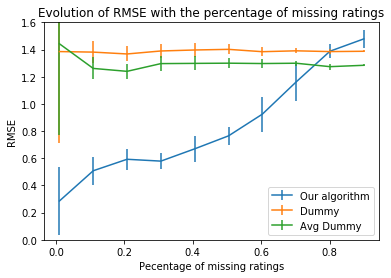

In [14]:
missing = np.linspace(0.01, 0.9, 10)
n_random = 10
errors = np.zeros(shape=(n_random, len(missing)))
errors_dummy = np.zeros(shape=(n_random, len(missing)))
errors_avg = np.zeros(shape=(n_random, len(missing)))
for i in range(n_random):
    rs = np.random.RandomState()
    for j, missing_percentage in enumerate(missing):
        # Create the mask
        mask = rs.rand(G.N)
        mask = (mask > missing_percentage).astype(float)
        inverse_mask = mask * -1 + 1
        noisy = signal * mask
        noisy = noisy + mean_signal * inverse_mask
        # Compute errors

        test_true = signal * inverse_mask
        test_true = test_true[test_true != 0]

        reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=best_gamma), 1, 5)
        test_reconstructed = reconstructed * inverse_mask
        test_reconstructed = test_reconstructed[test_reconstructed != 0]
        if np.count_nonzero(test_true) > 0:
            errors[i,j] = np.sqrt(mean_squared_error(test_true, test_reconstructed))
        
        test_dummy = np.ones(len(signal)) * inverse_mask * np.mean(signal)
        test_dummy = test_dummy[test_dummy != 0]
        if np.count_nonzero(test_true) > 0:
            errors_dummy[i,j] = np.sqrt(mean_squared_error(test_true, test_dummy))
        
        avg_dummy = inverse_mask * mean_signal
        avg_dummy = avg_dummy[avg_dummy != 0]
        if np.count_nonzero(test_true) > 0:
            errors_avg[i,j] = np.sqrt(mean_squared_error(test_true, avg_dummy))
        
        clear_output(wait=True)
        print(f'{i,j} {(errors[i,j]):.3f}, {(errors_dummy[i,j]):.3f}, {(errors_avg[i,j]):.3f}')
        

plt.figure()
plt.errorbar(missing, np.mean(errors, axis=0), yerr=np.std(errors, axis=0), label="Our algorithm")
plt.errorbar(missing, np.mean(errors_dummy, axis=0), yerr=np.std(errors_dummy, axis=0), label="Dummy")
plt.errorbar(missing, np.mean(errors_avg, axis=0), yerr=np.std(errors_dummy, axis=0), label="Avg Dummy")
plt.ylim([0,1.6])
#plt.plot(missing, np.ones(len(missing))*dummy_error, label= "Pseudo dummy error")
plt.legend()
plt.title("Evolution of RMSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("RMSE")
plt.savefig(RESULT_PATH+'evolution_rmse_missing.eps')
plt.show()

...

## Entire network

### Test with one user

We will test the signal now on the full network (still only for user 13). The principle is the same, but we have to be careful when designing the mask. We set it to zero for every unknown entry. 30% of the known ratings will be used for testing, which means they are zero in the initial mask, too. The remaining entries will be set to one.

In [15]:
user_id = 13
signal = ratings.loc[user_id]

In [16]:
# Laod graph
G = graphs.Graph(adjacency)
G.set_coordinates()

In [17]:
def create_mask(signal, valid_percent, test_percent):
    mask = np.zeros(len(signal))
    validation_mask = np.zeros(len(signal))
    test_mask = np.zeros(len(signal))
    for i in range(len(signal)):
        if signal[i] != 0:
            x = random()
            if x < test_percent:
                test_mask[i] = 1
            elif x < test_percent + valid_percent:
                validation_mask[i] = 1
            else:
                mask[i] = 1
    return mask, validation_mask, test_mask

In [18]:
# create mask
mean_signal = compute_mean_signal(ratings, user_id)
mask, validation_mask, test_mask = create_mask(signal, 0.1, 0.1)
noisy_validation = signal * mask
noisy_validation = noisy_validation + mean_signal * (mask * -1 + 1)
validation_true = signal * validation_mask
validation_true = validation_true[validation_true != 0]

print("Percentage of missing data :", len(mask[mask!=1])/len(mask))

Percentage of missing data : 0.475


In [20]:
errors = []
best_error = np.inf
best_gamma = 0
interval = np.linspace(0, 30, 16)
interval[0] = 0.1

for gamma in interval:
    reconstructed = np.clip(tv_reg(G, noisy_validation, mask, gamma=gamma), 1, 5)
    
    if(np.isnan(reconstructed).any()):
        errors.append(np.nan)
        continue
    # Compute errors
    validation_reconstructed = reconstructed * validation_mask
    validation_reconstructed = validation_reconstructed[validation_reconstructed != 0]
    error = np.sqrt(mean_squared_error(validation_true, validation_reconstructed))
    clear_output(wait=True)
    print(gamma, error)
    if error < best_error:
        best_error = error
        best_gamma = gamma

    errors.append(error)
    
# retrain using train and validation data
mask += validation_mask
noisy_test = signal * mask
noisy_test = noisy_test + mean_signal * (mask * -1 + 1)
reconstructed = np.clip(tv_reg(G, noisy_test, mask, gamma=best_gamma), 1, 5)  

30.0 2.8130132381950976


Best gamma :  6.0
Validation RMSE :  1.1935527388803788
Test RMSE :  1.337850462480039
Dummy RMSE :  1.3636610020476814


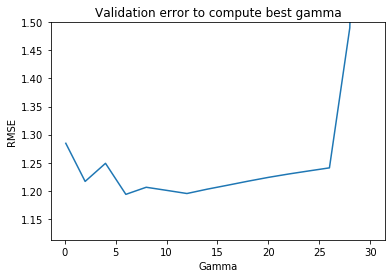

In [21]:
test_true = signal * test_mask
test_true = test_true[test_true != 0]

test_reconstructed = reconstructed * test_mask
test_reconstructed = test_reconstructed[test_reconstructed != 0]

test_noisy = noisy_test * test_mask
test_noisy = test_noisy[test_noisy != 0]

print("Best gamma : ", best_gamma)
print("Validation RMSE : ", best_error)
print("Test RMSE : ", np.sqrt(mean_squared_error(test_true, test_reconstructed)))
print("Dummy RMSE : ", np.sqrt(mean_squared_error(test_true, test_noisy)))

plt.figure()
plt.plot(interval, errors)
plt.title("Validation error to compute best gamma")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.ylim(ymax = 1.5)
plt.show()

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


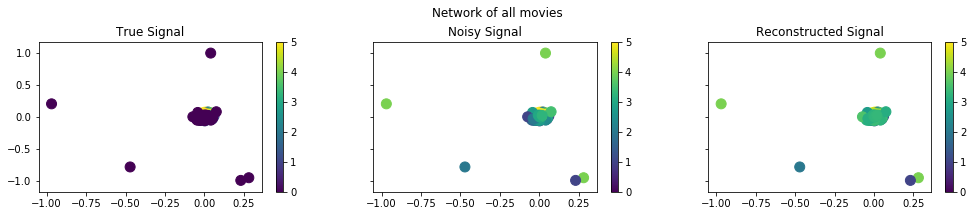

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


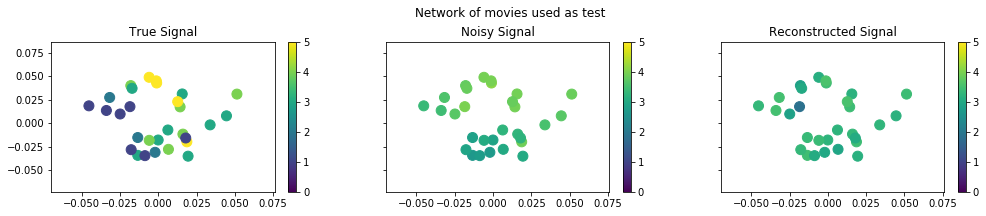

In [22]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True, figsize=(17, 3))
limits = [0, 5]
G.plot_signal(signal, ax=ax1, limits=limits, plot_name='True Signal')
G.plot_signal(noisy_test, ax=ax2, limits=limits, plot_name='Noisy Signal', show_edges = False)
G.plot_signal(reconstructed, ax=ax3, limits=limits, plot_name='Reconstructed Signal', show_edges= False)
plt.suptitle("Network of all movies")
plt.savefig(RESULT_PATH+'prediction_entire_network.eps')
plt.subplots_adjust(top=0.82)
plt.show()

signal_red = signal.copy()
signal_red[test_mask == 0] = np.nan
noisy_red = noisy_test.copy()
noisy_red[test_mask  == 0] = np.nan
reconstructed_red = reconstructed.copy()
reconstructed_red[test_mask == 0] = np.nan

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True, figsize=(17, 3))
limits = [0, 5]
G.plot_signal(signal_red, ax=ax1, limits=limits, plot_name='True Signal')
G.plot_signal(noisy_red, ax=ax2, limits=limits, plot_name='Noisy Signal', show_edges = False)
G.plot_signal(reconstructed_red, ax=ax3, limits=limits, plot_name='Reconstructed Signal', show_edges= False)
plt.suptitle("Network of movies used as test")
plt.savefig(RESULT_PATH+'prediction_entire_network_test.eps')
plt.subplots_adjust(top=0.82)
plt.show()

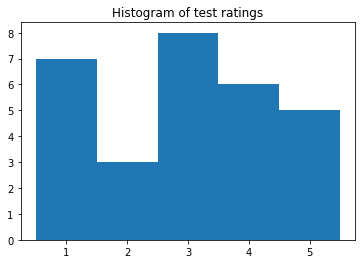

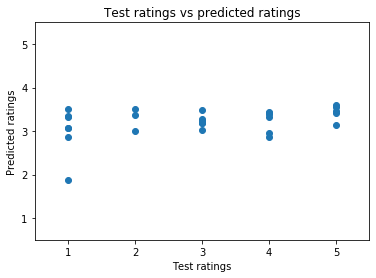

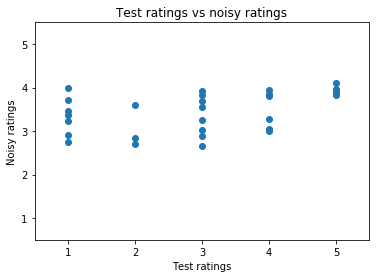

In [23]:
plt.figure()
plt.hist(signal[test_mask != 0], bins=[1, 2, 3, 4, 5, 6], align='left')
plt.title("Histogram of test ratings")
plt.show()

plt.figure()
plt.scatter(signal[test_mask == 1], reconstructed[test_mask == 1])
plt.xlim(0.5,5.5)
plt.ylim(0.5,5.5)
plt.title("Test ratings vs predicted ratings")
plt.xlabel("Test ratings")
plt.ylabel("Predicted ratings")
plt.show()

plt.figure()
plt.scatter(signal[test_mask == 1], noisy_test[test_mask == 1])
plt.xlim(0.5,5.5)
plt.ylim(0.5,5.5)
plt.title("Test ratings vs noisy ratings")
plt.xlabel("Test ratings")
plt.ylabel("Noisy ratings")
plt.show()

### Test over all users
Now we will test the TV regularization over all users. Each of them reprensent a signal lying on the graph. We will use a test set of 30% of the rated movie for all users

#### Fast test for all users (without validation using gamma = 8 for all users)

In [25]:
# Laod graph
G = graphs.Graph(adjacency)
G.set_coordinates()

errors = []
reconstruction = np.zeros(ratings.shape)
gamma = 8

for idx, signal in ratings.iterrows():
    print(f'seen users {idx}')
    
    # Create masks
    mask, validation_mask, test_mask = create_mask(signal, 0.0, 0.3)
    
    mean_signal = compute_mean_signal(ratings, user_id)
    
    # Create the noisy signal 
    noisy = signal * mask
    noisy = noisy + mean_signal * (mask * -1 + 1)
    
    # Predict ratings
    reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=gamma), 1, 5)
    reconstruction[idx - 1] = reconstructed
    
    # Compute the error
    test_true = signal * test_mask
    test_true = test_true[test_true != 0]
    
    test_reconstructed = reconstructed * test_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    
    if np.count_nonzero(test_true) > 0:
        error =  np.sqrt(mean_squared_error(test_true, test_reconstructed))
        errors.append(error)
    
    
    clear_output(wait=True)
    print(f'current average error: {np.mean(errors)}')
    np.savetxt(RESULT_PATH +'ratings_predicted_rating_fast.csv',reconstruction, delimiter=',')
    np.savetxt(RESULT_PATH +'ratings_error_rating_fast.csv',errors, delimiter=',')
    
plt.figure()
plt.hist(errors)
plt.title("Histogram of test errors")
plt.show()

current average error: 1.3500129216110095
seen users 2


KeyboardInterrupt: 

#### Slow test for all users (with validation of gamma for each user)

In [ ]:
test_errors = []
best_gammas = []
percentage_data = []
for idx, signal in ratings.iterrows():
    # create mask
    mask, validation_mask, test_mask = create_mask(signal, 0.2, 0.2)
    #print(G.N, np.count_nonzero(signal))
    noisy_validation = signal * mask
    noisy_validation = noisy_validation + mean_signal * (mask * -1 + 1)
    errors = []
    best_error = np.inf
    best_gamma = 0
    interval = np.linspace(4,11,3)
    for gamma in interval:
        reconstructed = np.clip(tv_reg(G, noisy_validation, mask, gamma=gamma), 1, 5)

        # Compute errors
        validation_true = signal * validation_mask
        validation_true = validation_true[validation_true != 0]

        validation_reconstructed = reconstructed * validation_mask
        validation_reconstructed = validation_reconstructed[validation_reconstructed != 0]
        error = mean_squared_error(validation_true, validation_reconstructed)
        display(error)
        if error < best_error:
            best_error = error
            best_gamma = gamma
        errors.append(error)

    # retrain using train and validation data
    mask += validation_mask
    noisy_test = signal * mask
    reconstructed = np.clip(tv_reg(G, noisy_test, mask, gamma=best_gamma), 1, 5)

    test_true = signal * test_mask
    test_true = test_true[test_true != 0]

    test_reconstructed = reconstructed * test_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    
    test_error = mean_squared_error(test_true, test_reconstructed)
    print(test_error)
    plt.scatter(signal[test_mask == 1], reconstructed[test_mask == 1])
    plt.ylim(0.5,5.5)
    plt.xlim(0.5,5.5)
    plt.savefig(f'{RESULT_PATH}/Correlation/{idx}.png')
    
    plt.show()
    
    best_gammas.append(best_gamma)
    test_errors.append(test_error)
    percentage_data.append(len(noisy_test[noisy_test != 0])/len(signal))
    clear_output(wait=True)
    display(f'{np.mean(best_gammas)},{np.std(best_gammas)}')

## Using Movie feature Graph



In [2]:
adjacency = np.loadtxt(GENERATED_PATH+'movie_features_adj.csv', delimiter=',')

In [3]:
ratings[ratings > 0].count(axis=1).sort_values(ascending=False)

UserId
13     304
276    293
416    270
655    270
303    262
      ... 
300     10
242      9
565      7
558      7
855      4
Length: 943, dtype: int64

In [4]:
def compute_mean_signal(ratings, user_id):
    ratings_without_users = ratings.drop(index = user_id)
    mean_counter = ratings_without_users.copy().astype('float')
    mean_counter[mean_counter == 0] = np.nan
    mean_signal = np.nanmean(mean_counter, axis = 0)
    return mean_signal

In [5]:
user_id = 13
signal = ratings.loc[user_id].reset_index(drop = True)
indexes = np.array(signal[signal >0].index.to_list())
mean_signal = compute_mean_signal(ratings, user_id)
mean_signal = mean_signal[indexes]

We use the first 161 movies which are all rated by this user. So we can see the evolution of the MSE with the percentage of missing ratings

In [6]:
adj = adjacency[indexes][:, indexes]
signal = signal[indexes]
G = graphs.Graph(adj)
G.set_coordinates()

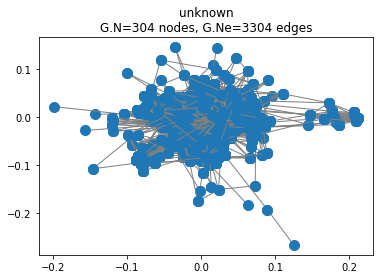

In [7]:
# Load graph
G = graphs.Graph(adj)
G.set_coordinates()
G.plot()

In [8]:
# This function solve the optimization problem of the TV regularization
def tv_reg(G, noisy, mask, gamma = 3):
    
    # Set the functions in the problem
    d = pyunlocbox.functions.dummy()
    r = pyunlocbox.functions.norm_l1()
    f = pyunlocbox.functions.norm_l2(w=mask, y=noisy, lambda_=gamma)

    # Define the solver
    G.compute_differential_operator()
    L = G.D.toarray()
    step = 0.999 / (1 + np.linalg.norm(L))
    solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

    # Solve the problem
    x0 = noisy.copy()
    prob1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000, verbosity='NONE')

    return prob1['sol']

In [9]:
# Create the mask
rs = np.random.RandomState(41)
mask = rs.rand(G.N)
mask = (mask < 0.7).astype(float)
inverse_mask = mask * -1 + 1
noisy = signal * mask

# Add the mean of ratings for each movie
noisy = noisy + mean_signal * inverse_mask

test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

We perform a validation test for the parameter gamma

Best gamma :  2.5555555555555554
RMSE :  1.493849681824174


C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\pyunlocbox\functions.py:494: RuntimeWarning: overflow encountered in double_scalars
  return self.lambda_ * np.sum((self.w * sol)**2)
C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\pyunlocbox\solvers.py:286: RuntimeWarning: invalid value encountered in double_scalars
  relative = np.abs((current - last) / div)
C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\pyunlocbox\functions.py:494: RuntimeWarning: overflow encountered in square
  return self.lambda_ * np.sum((self.w * sol)**2)


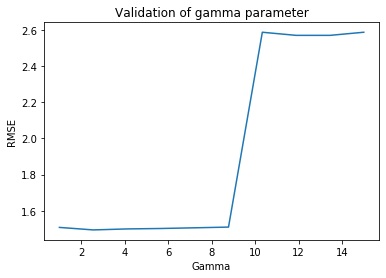

In [10]:
# Reconstruct the signal
errors = []
best_error = np.inf
best_gamma = 0
gamma_range = np.linspace(0,15,10)
for gamma in gamma_range:
    reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=gamma), 1, 5)

    test_reconstructed = reconstructed * inverse_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
    clear_output(wait = True)
    print(f'gamma: {gamma}, error {error}')
    if error < best_error:
        best_error = error
        best_gamma = gamma
    errors.append(error)

# we compute the mean squared error only between the ratings we didn't know
clear_output(wait = True)
print("Best gamma : ", best_gamma)
print("RMSE : ", best_error)

# We reconstruct the signal using the best gamma
reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=13), 1, 5)

# Plot validation
plt.figure()
plt.plot(gamma_range, errors)
plt.title("Validation of gamma parameter")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.show()

### Plot the signal
upper row is the entire available data.
the lower row shows only the test split

C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\pygsp\plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


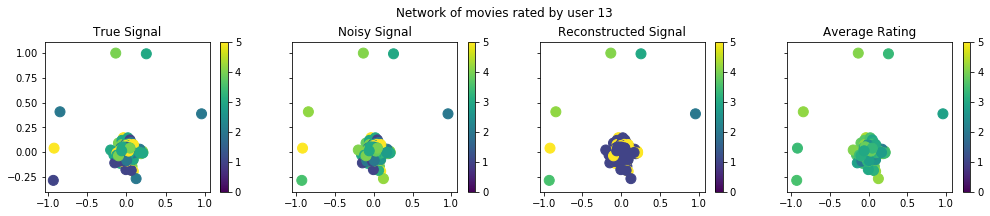

C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


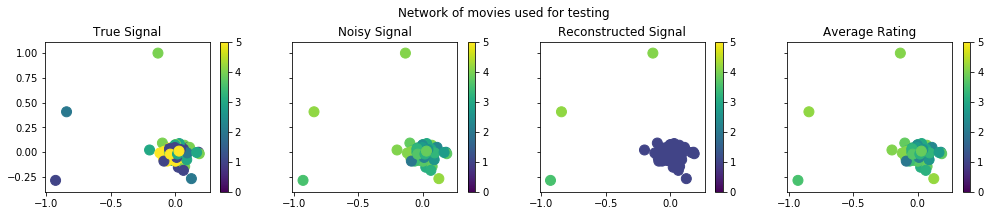

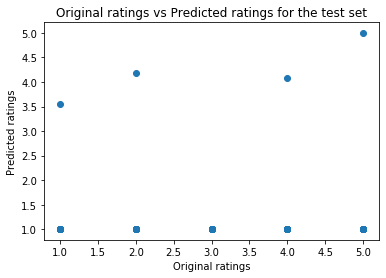

In [11]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, sharey=True, figsize=(17, 3))
limits = [0, 5]
G.plot_signal(signal, ax=ax1, limits=limits, plot_name='True Signal')
G.plot_signal(noisy, ax=ax2, limits=limits, plot_name='Noisy Signal', show_edges = False)
G.plot_signal(reconstructed, ax=ax3, limits=limits, plot_name='Reconstructed Signal', show_edges= False)
G.plot_signal(mean_signal, ax=ax4, limits=limits, plot_name='Average Rating', show_edges= False)
plt.suptitle("Network of movies rated by user 13")
plt.savefig(RESULT_PATH+'prediction_user_13.eps')
plt.subplots_adjust(top=0.82)
plt.show()


signal_red = signal.copy()
signal_red[mask != 0] = np.nan
noisy_red = noisy.copy()
noisy_red[mask != 0] = np.nan
reconstructed_red = reconstructed.copy()
reconstructed_red[mask != 0] = np.nan
mean_signal_red = mean_signal.copy()
mean_signal_red[mask != 0] = np.nan

fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, sharey=True, figsize=(17, 3))
G.plot_signal(signal_red, ax=ax1, limits=limits, plot_name='True Signal', show_edges = False)
G.plot_signal(noisy_red, ax=ax2, limits=limits, plot_name='Noisy Signal', show_edges = False)
G.plot_signal(reconstructed_red, ax=ax3, limits=limits, plot_name='Reconstructed Signal', show_edges = False)
G.plot_signal(mean_signal_red, ax=ax4, limits=limits, plot_name='Average Rating', show_edges = False)
plt.suptitle("Network of movies used for testing")
plt.savefig(RESULT_PATH+'prediction_user_13_test_only.eps')
plt.subplots_adjust(top=0.82)
plt.show()

plt.figure()
plt.scatter(signal[mask == 0], reconstructed[mask == 0])
plt.title("Original ratings vs Predicted ratings for the test set")
plt.xlabel("Original ratings")
plt.ylabel("Predicted ratings")
plt.savefig(RESULT_PATH+'scatter_prediction_user_13.eps')
plt.show()

We will compare this results whith a dummy program which always return the mean of the rating of the user and another one which always return the average ratings of each movie.

In [12]:
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

# Return the mean of the ratings of the user
test_reconstructed = np.ones(len(signal)) * inverse_mask * np.mean(signal)
test_reconstructed = test_reconstructed[test_reconstructed != 0]

# we compute the mean squared error only between the ratings we didn't know
dummy_error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
print("Dummy RMSE : ", dummy_error)

Dummy RMSE :  1.475876622741737


In [13]:
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

# Return the mean of the ratings of each movie
test_reconstructed = inverse_mask * mean_signal
test_reconstructed = test_reconstructed[test_reconstructed != 0]

# we compute the mean squared error only between the ratings we didn't know
dummy_error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
print("Dummy RMSE : ", dummy_error)

Dummy RMSE :  1.3233054619146423


We perform better than the dummy programs !

Now let's look at how the RMSE evolve with the percentage of missing value.

In [ ]:
missing = np.linspace(0.01, 0.9, 10)
n_random = 10
errors = np.zeros(shape=(n_random, len(missing)))
errors_dummy = np.zeros(shape=(n_random, len(missing)))
errors_avg = np.zeros(shape=(n_random, len(missing)))
for i in range(n_random):
    rs = np.random.RandomState()
    for j, missing_percentage in enumerate(missing):
        # Create the mask
        mask = rs.rand(G.N)
        mask = (mask > missing_percentage).astype(float)
        inverse_mask = mask * -1 + 1
        noisy = signal * mask
        noisy = noisy + mean_signal * inverse_mask
        # Compute errors

        test_true = signal * inverse_mask
        test_true = test_true[test_true != 0]

        reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=best_gamma), 1, 5)
        test_reconstructed = reconstructed * inverse_mask
        test_reconstructed = test_reconstructed[test_reconstructed != 0]
        if np.count_nonzero(test_true) > 0:
            errors[i,j] = np.sqrt(mean_squared_error(test_true, test_reconstructed))
        
        test_dummy = np.ones(len(signal)) * inverse_mask * np.mean(signal)
        test_dummy = test_dummy[test_dummy != 0]
        if np.count_nonzero(test_true) > 0:
            errors_dummy[i,j] = np.sqrt(mean_squared_error(test_true, test_dummy))
        
        avg_dummy = inverse_mask * mean_signal
        avg_dummy = avg_dummy[avg_dummy != 0]
        if np.count_nonzero(test_true) > 0:
            errors_avg[i,j] = np.sqrt(mean_squared_error(test_true, avg_dummy))
        
        clear_output(wait=True)
        print(f'{i,j} {(errors[i,j]):.3f}, {(errors_dummy[i,j]):.3f}, {(errors_avg[i,j]):.3f}')
        

plt.figure()
plt.errorbar(missing, np.mean(errors, axis=0), yerr=np.std(errors, axis=0), label="Our algorithm")
plt.errorbar(missing, np.mean(errors_dummy, axis=0), yerr=np.std(errors_dummy, axis=0), label="Dummy")
plt.errorbar(missing, np.mean(errors_avg, axis=0), yerr=np.std(errors_dummy, axis=0), label="Avg Dummy")
plt.ylim([0,1.6])
#plt.plot(missing, np.ones(len(missing))*dummy_error, label= "Pseudo dummy error")
plt.legend()
plt.title("Evolution of RMSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("RMSE")
plt.savefig(RESULT_PATH+'evolution_rmse_missing.eps')
plt.show()

(1, 0) 0.521, 0.493, 0.668
